<a href="https://colab.research.google.com/github/nbht98/attack_cat_or_dog_classification/blob/master/Test_create_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

# Define Constants
!wget https://raw.githubusercontent.com/nbht98/attack_cat_or_dog_classification/master/cord.json
!wget https://raw.githubusercontent.com/nbht98/attack_cat_or_dog_classification/master/cord.h5

FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

from keras.models import model_from_json

# Model reconstruction from JSON file
with open('cord.json', 'r') as f:
    target_model = model_from_json(f.read())

# Load weights into the new model
target_model.load_weights('cord.h5')

!pip3 install mia
# Import library 
import numpy as np

from absl import app
from absl import flags

import tensorflow as tf
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

from mia.estimators import ShadowModelBundle, AttackModelBundle, prepare_attack_data

def attack_model_fn():
    """Attack model that takes target model predictions and predicts membership.
    Following the original paper, this attack model is specific to the class of the input.
    AttachModelBundle creates multiple instances of this model for each class.
    """
    model = tf.keras.models.Sequential()

    model.add(layers.Dense(128, activation="relu", input_shape=(NUM_CLASSES,)))

    model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
    model.add(layers.Dense(64, activation="relu"))

    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

def target_model_fn():
  model = Sequential()

  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

  model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
  return model

--2020-01-09 03:40:33--  https://raw.githubusercontent.com/nbht98/attack_cat_or_dog_classification/master/cord.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6533 (6.4K) [text/plain]
Saving to: ‘cord.json’

cord.json           100%[===================>]   6.38K  --.-KB/s    in 0s      

2020-01-09 03:40:33 (167 MB/s) - ‘cord.json’ saved [6533/6533]

--2020-01-09 03:40:36--  https://raw.githubusercontent.com/nbht98/attack_cat_or_dog_classification/master/cord.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51813824 (49M) [applicatio

In [0]:
import cv2
sample0 = '0a.jpg'
image0 = cv2.imread(sample0, cv2.IMREAD_COLOR)
res0 = cv2.resize(image0, dsize=(128, 128))

image_0 = np.array(res0)

sample1 = '1.jpg'
image1 = cv2.imread(sample1, cv2.IMREAD_COLOR)
res1 = cv2.resize(image1, dsize=(128, 128))

image_1 = np.array(res1)


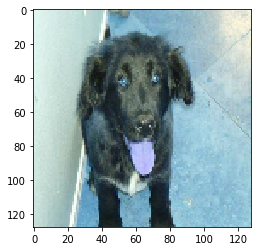

In [14]:
plt.imshow(np.squeeze(image_1))

In [15]:
target_model.predict_proba(image_1.reshape(1, 128*3//3, 128, 3))

array([[0., 1.]], dtype=float32)

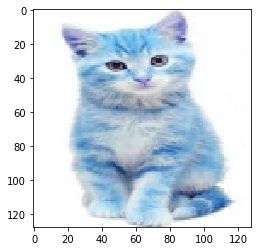

In [16]:
plt.imshow(np.squeeze(image_0))

In [17]:
target_model.predict_proba(image_0.reshape(1, 128*3//3, 128, 3))

array([[1., 0.]], dtype=float32)

In [0]:
x_dog = synthesize1(target_model, image_1, fixed_cls=1, k_max=128*3, n_features=(128*3, 128), vertical=True)

array([[0., 1.]], dtype=float32)

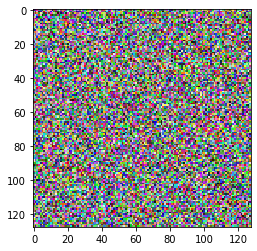

In [41]:
plt.imshow(np.squeeze(x_dog[0]))
x_dog[1]

In [0]:
x_cat = synthesize1(target_model, image_0, fixed_cls=0, k_max=128*3, n_features=(128*3, 128), vertical=False)

In [98]:
x_cat

(False, False)

In [0]:
x_dog2 = synthesize2(target_model, image_1, fixed_cls=1, k_max=128*3, n_features=(128*3, 128), vertical=True)

array([[0., 1.]], dtype=float32)

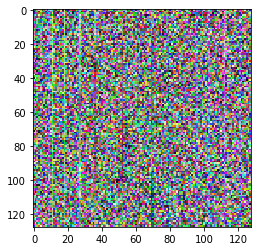

In [49]:
plt.imshow(np.squeeze(x_dog2[0]))
x_dog2[1]

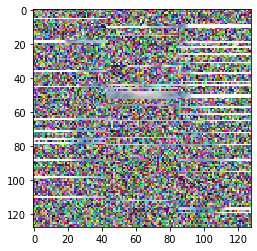

In [92]:
k_max = 128*6
x_cat2 = synthesize2(target_model, image_0, fixed_cls=0, k_max=k_max, n_features=(128*3, 128), vertical=False)
plt.imshow(np.squeeze(x_cat2[0]))


In [0]:
def features_generator(n_features: tuple, dtype: str, rang: tuple = (0, 255)) -> np.ndarray:
    """
    Creates a n features vector with uniform features
    sampled from a given range.
    Parameters
    ----------
    n_features: tuple
        number of features
    dtype: str
        type of the features. All the features must will have the same type.
    rang: tuple(int, int)
        range of the random uniform population from
        where to drawn samples
    Returns
    -------
    np.ndarray
        features vector
    """
    # D-fence params
    if dtype not in ("bool", "int", "float"):
        raise ValueError("Parameter `dtype` must be 'bool', 'int' or 'float'")
    if dtype == "bool":
        x = np.random.randint(0, 2, size=n_features)
    if dtype == "int":
        x = np.random.randint(rang[1], size=n_features)
    if dtype == "float":
        x = np.random.uniform(rang[0], rang[1], n_features)
    return x.reshape((n_features[0], n_features[1]))


def feature_randomizer(x: np.ndarray, n_features: tuple, k: int, dtype: str, rang: tuple = (0, 255), vertical=True) -> np.ndarray:
    """
    Randomizes k features from feature vector x
    Parameters
    ----------
    x: np.ndarray
        input array that will be modified
    k: int
        number of features to modify
    dtype: str
        type of the features. It only accepts uniform dtype.
    rang: tuple(int, int)
        range of the random uniform population from 
        where to drawn samples
    Returns
    -------
    x: np.ndarray
        input vector with k modified features
    """
    if vertical:
      idx_to_change = np.random.randint(0, n_features[1], size=k)
      new_feats = features_generator(n_features=(n_features[0], k), dtype="int", rang=rang)
      x[:,idx_to_change] = new_feats
    else:
      idx_to_change = np.random.randint(0, n_features[0], size=k)
      new_feats = features_generator(n_features=(k, n_features[1]), dtype="int", rang=rang)
      x[idx_to_change] = new_feats
    return x


def synthesize1(
    target_model, sample: np.ndarray, fixed_cls: int, k_max: int, dtype: str="int", n_features: tuple = (128*3,128), vertical=True) -> np.ndarray:
    """
    Generates synthetic records that are classified
    by the target model with high confidence.
    Parameters
    ----------
    target_model: estimator
        Estimator that returns a class probability vector
        from an input features vector. Implemented for
        sklearn.base.BaseEstimator with `predict_proba()`
        method.
    fixed_cls: int
        target model class to create data point from
    k_max: int
        max "radius" of feature perturbation
    
    dtype: str
        dtype of the features (float, int, bool)
    n_features: int
        number of features per input vector
    
    Returns
    -------
    np.ndarray
        synthetic feature vector
    False
        If failed to synthesize vector.
        This may be becaus number of iters exceded
    """

    # if not hasattr(target_model, "predict_proba"):
    #     raise AttributeError("target_model must have predict_proba() method")

    # if not hasattr(target_model, "n_features_") and n_features is None:
    #     raise ValueError("please specify the number of features in `n_features`")
    # else:
    #     n_features = target_model.n_features_

    x = features_generator(n_features, dtype=dtype, rang=(0,255))  # random record

    y_c_current = 0  # target model’s probability of fixed class
    n_rejects = 0  # consecutives rejections counter
    k = k_max
    k_min = 1
    max_iter = 10
    conf_min = 0.8# min prob cutoff to consider a record member of the class
    rej_max = 5  # max number of consecutive rejections

    # x = np.array(sample, copy=True)
    # x = x.reshape(-1, x.shape[1])
    # x = feature_randomizer(x, n_features, k, dtype='int', rang=(0, 255), vertical=vertical)

    for _ in range(max_iter):
        y = target_model.predict_proba(x.reshape(1, n_features[0]//3, n_features[1], 3))  # query target model
        y_c = y.flat[fixed_cls]
        if y_c >= y_c_current:
            if (y_c > conf_min) and (fixed_cls == np.argmax(y)):
                return x.reshape(1, n_features[0]//3, n_features[1], 3), y
            # reset vars
            x_new = x
            y_c_current = y_c
            n_rejects = 0
        else:
            n_rejects += 1
            if n_rejects > rej_max:
                k = max(k_min, int(np.ceil(k / 2)))
                n_rejects = 0
        # x = feature_randomizer(x_new, k, dtype=dtype, rang=(0, 1))
        # x_new = feature_randomizer(x, 3, dtype="int", rang=(0, 255))
        x = feature_randomizer(x_new, n_features, k, dtype='int', rang=(0, 255), vertical=vertical)
    return False, False


def synthesize2(
    target_model, sample: np.ndarray, fixed_cls: int, k_max: int, dtype: str="int", n_features: tuple = (128*3,128), vertical=True) -> np.ndarray:
    """
    Generates synthetic records that are classified
    by the target model with high confidence.
    Parameters
    ----------
    target_model: estimator
        Estimator that returns a class probability vector
        from an input features vector. Implemented for
        sklearn.base.BaseEstimator with `predict_proba()`
        method.
    fixed_cls: int
        target model class to create data point from
    k_max: int
        max "radius" of feature perturbation
    
    dtype: str
        dtype of the features (float, int, bool)
    n_features: int
        number of features per input vector
    
    Returns
    -------
    np.ndarray
        synthetic feature vector
    False
        If failed to synthesize vector.
        This may be becaus number of iters exceded
    """

    # if not hasattr(target_model, "predict_proba"):
    #     raise AttributeError("target_model must have predict_proba() method")

    # if not hasattr(target_model, "n_features_") and n_features is None:
    #     raise ValueError("please specify the number of features in `n_features`")
    # else:
    #     n_features = target_model.n_features_

    # x = features_generator(n_features, dtype=dtype, rang=(0,255))  # random record

    y_c_current = 0  # target model’s probability of fixed class
    n_rejects = 0  # consecutives rejections counter
    k = k_max
    k_min = 1
    max_iter = 10
    conf_min = 0.8# min prob cutoff to consider a record member of the class
    rej_max = 5  # max number of consecutive rejections

    x = np.array(sample, copy=True)
    x = x.reshape(-1, x.shape[1])
    x = feature_randomizer(x, n_features, k, dtype='int', rang=(0, 255), vertical=vertical)

    for _ in range(max_iter):
        y = target_model.predict_proba(x.reshape(1, n_features[0]//3, n_features[1], 3))  # query target model
        y_c = y.flat[fixed_cls]
        if y_c >= y_c_current:
            if (y_c > conf_min) and (fixed_cls == np.argmax(y)):
                return x.reshape(1, n_features[0]//3, n_features[1], 3), y
            # reset vars
            x_new = x
            y_c_current = y_c
            n_rejects = 0
        else:
            n_rejects += 1
            if n_rejects > rej_max:
                k = max(k_min, int(np.ceil(k / 2)))
                n_rejects = 0
        # x = feature_randomizer(x_new, k, dtype=dtype, rang=(0, 1))
        # x_new = feature_randomizer(x, 3, dtype="int", rang=(0, 255))
        x = feature_randomizer(x_new, n_features, k, dtype='int', rang=(0, 255), vertical=vertical)
    return False, False



In [0]:

def synthesize_batch(target_model, n_features, lst_class, lst_sample, n_records, k_max, vertical=True):
    """
    Synthesize a batch of records
    """
    x_synth = np.zeros((n_records,n_features[0]//3,n_features[1], 3))
    y_synth = np.zeros((n_records, 2))
    count = 0
    for i in range(n_records//2):
      print(i)
      for j in lst_class:
        if j == 0:
          k_max = n_features[0] * 3
          vertical = True
        else:
          k_max = n_features[1]
          vertical = False
        while True:  # repeat until synth finds record
            x, y = synthesize(target_model, lst_sample[j], fixed_cls=j, k_max=k_max, n_features=n_features, vertical=vertical)
            if isinstance(x, np.ndarray):
                break
        x_synth[count] = x
        y_synth[count] = y
        count += 1
    return x_synth, y_synth

